In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader, sampler
# load modules
from pytorchtools import EarlyStopping #, Encoder, Decoder

torch.manual_seed(1)

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

cpu


# Data Processing

In [3]:
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2

class BuildVocab:
    def __init__(self):
        self.word2index = {'<PAD>': PAD_TOKEN, '<SOS>': SOS_TOKEN, '<EOS>': EOS_TOKEN}
        self.word2count = {}
        self.index2word = {PAD_TOKEN:'<PAD>', SOS_TOKEN: '<SOS>', EOS_TOKEN: '<EOS>'}
        self.num_words = 3
    
    def fromCorpus(self, corpus):
        for line in corpus:
            self.fromSentence(line)
    
    def fromSentence(self, line):
        for word in line:
            self.toVocab(word)
    
    def toVocab(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

In [4]:
df = pd.read_csv("protein_seq.csv", index_col=0)
df.drop_duplicates(inplace=True)
print("Trimming sentence from: ", df.shape)

# chop off the sequence length
# keep sentence length <= a threshhold
mask = (df["meso_seq"].str.len()<=100)&(df["thermal_seq"].str.len()<=100) ########
df = df.loc[mask].reset_index(drop=True)
print("To: ", df.shape)

input_seq = df["meso_seq"].tolist()
target_seq = df["thermal_seq"].tolist()

voc = BuildVocab()
voc.fromCorpus(input_seq + target_seq)
print("Word Count: ", len(voc.word2index))

Trimming sentence from:  (401885, 4)
To:  (1686, 4)
Word Count:  24


In [5]:
# mapping character to index for all sentences
def map_character(voc, line):
    return [voc.word2index[word] for word in line] + [EOS_TOKEN] # EOS token

def sequence_padding(ctx, max_len):
    for index, seq in enumerate(ctx):
        pad_to_seq = [PAD_TOKEN]*(max_len - len(seq))
        ctx[index] = [*seq, *pad_to_seq]
    return ctx

def target_binary_mask(ctx):
    for i, line in enumerate(ctx):
        for j, index in enumerate(line):
            if index != 0:
                ctx[i][j] = 1
    return ctx

In [6]:
# input and output batch shape should be (max_length, batch_size)
def input_init(input_batch, voc):
    mapped_batch = [map_character(voc, line) for line in input_batch]
    lengths = [len(seq_len) for seq_len in mapped_batch]
    length_t = torch.tensor(lengths)
    max_input_len = max(lengths)
    padded_batch = sequence_padding(mapped_batch, max_input_len)
    padded_batch_t = torch.LongTensor(padded_batch).t()
    return padded_batch_t, length_t

def target_init(target_batch, voc):
    mapped_batch = [map_character(voc, line) for line in target_batch]
    max_target_len = max(len(seq_len) for seq_len in mapped_batch)
    padded_batch = sequence_padding(mapped_batch, max_target_len)
    padded_batch_t = torch.LongTensor(padded_batch).t()
    target_mask = target_binary_mask(padded_batch)
    target_mask_t = torch.ByteTensor(target_mask).t()
    return max_target_len, padded_batch_t, target_mask_t

def batch_inp_out(loader):
    batches = []
    for input_batch, target_batch in loader:
        # sort lengths to pack_padded_sequence later
        input_batch, target_batch = zip(*sorted(zip(input_batch, target_batch),
                                                key=lambda x:len(x[0]),
                                                reverse=True))
        input_batch = list(input_batch)
        target_batch = list(target_batch)
        input_t, lengths = input_init(input_batch, voc)
        max_target_len, target_t, mask_t = target_init(target_batch, voc)
        batches.append((input_t, lengths, max_target_len, target_t, mask_t))
    return batches

def train_val_split(input_seq, target_seq, batch_size):
    num_train = len(input_seq)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(0.1 * num_train)) # validate on 10% of data
    train_indx, val_indx = indices[split:], indices[:split]
    
    data = list(zip(input_seq, target_seq))
    train_sampler = sampler.SubsetRandomSampler(train_indx)
    val_sampler = sampler.SubsetRandomSampler(val_indx)
    
    train_loader = DataLoader(data, batch_size=batch_size, sampler=train_sampler, drop_last=True)
    val_loader = DataLoader(data, batch_size=batch_size, sampler=val_sampler, drop_last=True)
    
    train_batches = batch_inp_out(train_loader)
    val_batches = batch_inp_out(val_loader)
    return train_batches, val_batches

In [7]:
### test
train_batches, val_batches = train_val_split(input_seq, target_seq, 64)
# input_t, lengths, max_target_len, target_t, mask_t = train_batches[-1]
input_t, lengths, max_target_len, target_t, mask_t = val_batches[-1]
print("input sequences tensor: ", input_t.shape)
print("input length tensor: ", len(lengths))
print("max target length: ", max_target_len)
print("target sequences tensor: ", target_t.shape)
print("target binary mask: ", mask_t.shape)

input sequences tensor:  torch.Size([101, 64])
input length tensor:  64
max target length:  101
target sequences tensor:  torch.Size([101, 64])
target binary mask:  torch.Size([101, 64])


# Build Neural Network
## Part I: Encoder

In [8]:
### comment this part if import modules above
# network inherit from nn.Module (container) and override forward() method
class Encoder(nn.Module):
    def __init__(self, hidden_dim, embedding, layer_dim, dropout=0):
        super(Encoder, self).__init__()
        self.layer_dim, self.hidden_dim, self.embedding = layer_dim, hidden_dim, embedding
        # nn.GRU(input_dim, hidden_dim, layer_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, layer_dim, dropout=dropout, bidirectional=True)
    
    # input_seq: (max_length, b atch_size)
    # input_length: (batch_size)
    def forward(self, input_seq, input_length):
        
        # for each batch_size add a random feature with shape of embedding_dim
        # embeddings: (max_length, batch_size, embedding_dim=hidden_dim)
        embeddings = self.embedding(input_seq)
        
        # tensor will be concated in time axis
        # basically, it will again concat the first column (seq), second, ....
        # pack: (sum_seq_len, num_directions * hidden_size)
        pack = torch.nn.utils.rnn.pack_padded_sequence(embeddings, input_length)
        
        # hidden: (n_layers * num_directions, batch_size, hidden_size)
        outputs, hidden = self.gru(pack)
        
        # unpack outputs: (max_length, batch_size, num_direction * hidden_size)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        
        # sum bidirectional outputs
        outputs = outputs[:, :, :self.hidden_dim] + outputs[:, :, self.hidden_dim:]
        return outputs, hidden

In [9]:
## dimension test
rnn = nn.GRU(6, 20, 2, bidirectional=True)  # (input_size = features, hidden_size, n_layers)
inputs = torch.randn(5, 3, 6)  # (max_length, batch_size, input_size)
h0 = torch.randn(2*2, 3, 20)  # (n_layers * num_direction, batch_size, hidden_size)
output, hn = rnn(inputs, h0)
print("Output shape: ", output.shape)  # (max_length, batch_size, hidden_size)
print("hidden shape:", hn.shape)  # (n_layers * num_direction, batch_size, hidden_size)
output = output[:, :, :20] + output[:, :, 20:]
print("output shape: ", output.shape)

Output shape:  torch.Size([5, 3, 40])
hidden shape: torch.Size([4, 3, 20])
output shape:  torch.Size([5, 3, 20])


In [10]:
## something about pack_padded_sequence...
# (batch_size, max_length)
a = torch.tensor([[1, 2, 3, 4, 5], [6, 7, 8, 0, 0], [9, 10, 0, 0, 0]])
length = [5, 3, 2]
targets = nn.utils.rnn.pack_padded_sequence(a, length, batch_first=True)
print(targets[0]) # concat first element of every batch, second element of every batch...
print(targets[1]) # different batch size for each timestep

tensor([ 1,  6,  9,  2,  7, 10,  3,  8,  4,  5])
tensor([3, 3, 2, 1, 1])


## Part II. Decoder: token by token until EOS
Use current hidden state of the decoder and output of encoder.
Global attention's score function:
                      
$$
\begin{equation}
Scores = 
\begin{cases}
    h_t^T h_s & \text{dot}\\
    h_t W_a h_s & \text{general}\\
    v_a^T \tanh(W_a[h_t;h_s]) & \text{concat}
\end{cases}
\end{equation}\\
$$
Note: $h_t$ is the current target decoder state and $h_s$ is all encoder states (= encoder output). $W_a$ is the weight from linear layer.

In [11]:
### comment this part if modules loaded from above
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
    
    # current decoder state (ht): (1, batch_size, hidden_size) 
    # encoder output (hs): (max_length, batch_size, hidden_size)
    # return: (max_length, batch_size)
    def attn_dot(self, ht, hs):
        return torch.sum(ht * hs, dim=2) # sum across hidden_size
    
    # return: (batch_size, 1, max_length)
    def forward(self, ht, hs):
        # (batch_size, max_length)
        score = self.attn_dot(ht, hs).t()
        # normalize across each row so that the sum of each col in a row will be 1
        # and add one dimension
        return F.softmax(score, dim=1).unsqueeze(1)

In [12]:
## Test Attn
att = Attn('dot', 20)
ht = torch.randn(1, 5, 20)
hs = torch.randn(10, 5, 20)
att.forward(ht, hs).shape

torch.Size([5, 1, 10])

In [13]:
### comment this part if modules loaded above
class Decoder(nn.Module):
    # note: input_size=feature size, output_size = vocabulary size
    def __init__(self, method, embedding, hidden_size, output_size, n_layer=1, dropout=0):
        super(Decoder, self).__init__()
        self.method, self.hidden_size, self.output_size, self.n_layer = method, hidden_size, output_size, n_layer
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        # embed_size = hidden_size here
        self.gru = nn.GRU(hidden_size, hidden_size, n_layer, dropout=dropout)
        self.concat = nn.Linear(hidden_size*2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size) 
        self.attn = Attn(method, hidden_size)
    
    # decoder_input: (1, batch_size) one batch of words at a time
    # decoder_hidden: (n_layer * num_directional, batch_size, hidden_size)
    # encoder_output: (max_length, batch_size, hidden_size)
    def forward(self, decoder_input, decoder_hidden, encoder_output):
        # embeds: (1, batch_size, embed_size=hidden_size)
        embeds = self.embedding_dropout(self.embedding(decoder_input))

        # only one word, no need to pack padded sequence...
        
        # decoder_output: (1, batch_size, hidden_size)
        # hidden: (n_layers * num_directions, batch_size, hidden_size)
        decoder_output, hidden = self.gru(embeds, decoder_hidden)
        # calculate attention weight
        # score: (batch_size, 1, max_length)
        score = self.attn(decoder_output, encoder_output)
        # context: (batch_size, hidden_size)
        context = score.bmm(encoder_output.transpose(0, 1)).squeeze(1)
        # decoder_output: (batch_size, hidden_size)
        decoder_output = decoder_output.squeeze(0)
        # concat into (batch_size, hidden_size*2)
        linear_input = torch.cat((decoder_output, context), 1)
        concat_output = torch.tanh(self.concat(linear_input))
        # predict next word: (batch_size, vocab_size)
        output = F.softmax(self.out(concat_output), dim=1)
        return output, hidden

In [14]:
## test
linear_input_t = torch.randn(3, 8)  # (batch_size, hidden_size)
concat = nn.Linear(8, 4)
concat_output_t = torch.tanh(concat(linear_input_t))
out = nn.Linear(4, 5) 
output = F.softmax(out(concat_output_t), dim=1)
print(output.shape)
print(output)
f, t = output.topk(1) # torch.max(decoder_output, dim=1)
print(f)
print(t)

torch.Size([3, 5])
tensor([[0.1057, 0.1441, 0.1823, 0.4148, 0.1531],
        [0.1375, 0.1852, 0.1354, 0.2544, 0.2876],
        [0.1331, 0.1758, 0.1664, 0.2730, 0.2516]], grad_fn=<SoftmaxBackward>)
tensor([[0.4148],
        [0.2876],
        [0.2730]], grad_fn=<TopkBackward>)
tensor([[3],
        [4],
        [3]])


In [15]:
# calculate loss and ignore padded part
# dec_out: (batch_size, vocab_size)
def loss_func(dec_out, target, mask):
    # (batch_size, 1)
    target = target.view(-1, 1)
    # negative log likelihood
    crossEntropy = -torch.log(torch.gather(dec_out, 1, target).squeeze(1))
    # select non-zero elements and calculate the mean
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, mask.sum().item()

In [16]:
## test loss_func
dec_out = torch.randn(5, 7)
dec_out = F.softmax(dec_out, dim=1)
target = torch.LongTensor([3, 5, 4, 1, 2])
mask = torch.tensor([1, 1, 0, 0, 1], dtype=torch.uint8)
loss_func(dec_out, target, mask)
# print("Dec_out:", dec_out)
# target = target.view(-1, 1)
# print("target:", target)
# gather = torch.gather(dec_out, 1, target).squeeze(1)
# print("gather:", gather)
# crossEntropy = -torch.log(gather)
# print("crossEntropy:", crossEntropy)
# loss = crossEntropy.masked_select(mask)
# print("loss:", loss)

(tensor(2.1858), 3)

## Part III. Training Process

In [17]:
def loss_calulation(encoder, decoder, batch, batch_size, teacher_forcing_r):
    
    input_t, lengths, max_target_len, target_t, mask_t = batch
    
    input_t = input_t.to(device)
    lengths = lengths.to(device)
    target_t = target_t.to(device)
    mask_t = mask_t.to(device)
    
    encoder_output, encoder_hidden = encoder(input_t, lengths)
    decoder_input = torch.LongTensor([[SOS_TOKEN for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)
    # set initial decoder hidden state to the encoder's final state
    decoder_hidden = encoder_hidden[:decoder.n_layer]
    
    loss = 0
    print_loss = []
    nTotals = 0
    if np.random.random() < teacher_forcing_r:
        for step in range(max_target_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)
            # teacher forcing: next input is current target
            decoder_input = target_t[step].view(1, -1)
            mask_loss, nTotal = loss_func(decoder_output, target_t[step], mask_t[step])
            loss += mask_loss
            print_loss.append(mask_loss.item()*nTotal)
            nTotals += nTotal
    else:
        for step in range(max_target_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)
            # non teacher forcing: next input is current decoder output
            # choose the index of word with highest possibility
            _, indx = torch.max(decoder_output, dim=1) 
            decoder_input = torch.LongTensor([[indx[i] for i in range(batch_size)]])
            decoder_input.to(device)
            mask_loss, nTotal = loss_func(decoder_output, target_t[step], mask_t[step])
            loss += mask_loss
            print_loss.append(mask_loss.item()*nTotal)
            nTotals += nTotal
    
    return print_loss, loss, nTotals

In [18]:
# train for a fixed iterations
def train(input_seq, target_seq, batch_size, epochs, hidden_dim, embedding, encoder, decoder,
          encoder_opt, decoder_opt, teacher_forcing_r, epoch_from, folder, patience=20):
    
    avg_train_loss = []
    avg_val_loss = []
    
    train_batches, val_batches = train_val_split(input_seq, target_seq, batch_size)
    
    print(encoder)
    print(decoder)
    
    early_stopping = EarlyStopping(patience=patience)
    
    for epoch in range(epoch_from, epochs):
        ############
        # Training #
        ############
        encoder.train()
        decoder.train()
        train_loss = []
        for train_batch in train_batches:
            # initialize and move the model to GPU/CPU
            # set training mode
            encoder_opt.zero_grad()
            decoder_opt.zero_grad()

            print_loss, loss, nTotals = loss_calulation(encoder, decoder, train_batch, batch_size, teacher_forcing_r)

            loss.backward()

            _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
            _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)

            encoder_opt.step()  # update weights
            decoder_opt.step()
            
            train_loss.append(sum(print_loss) / nTotals)
        
        print("train_finished!")
        ##############
        # validation #
        ##############
        encoder.eval()
        decoder.eval()
        val_loss = []
        for val_batch in val_batches:
            print_loss, _, nTotals = loss_calulation(encoder, decoder, val_batch, batch_size, teacher_forcing_r)
            
            val_loss.append(sum(print_loss) / nTotals)  # loss for batches

        avg_train_loss.append(np.average(train_loss))  # loss for epochs
        avg_val_loss.append(np.average(val_loss))
        print("Epoch: {}; train loss: {:.4}; val loss: {:.4}".format(epoch + 1, avg_train_loss[-1], avg_val_loss[-1]))
        
        model_states = (
            epoch,
            encoder.state_dict(),
            decoder.state_dict(),
            encoder_opt.state_dict(),
            decoder_opt.state_dict(),
            voc.__dict__,
            embedding.state_dict())
        
        early_stopping(avg_val_loss[-1], model_states, folder)
        
        if early_stopping.early_stop:
            print('EarlyStopping ...')
            break
        
    return avg_train_loss, avg_val_loss

## Part IV. Run the Model

In [21]:
# hyperparameters
hidden_dim = 300
enc_layer_dim = 2
dec_layer_dim = 2
dropout = 0.1
attn_method = "dot"
lr = 0.0001
teacher_forcing_r = 0.5
batch_size = 64
epochs = 1000

In [30]:
def run(folder, loadMode):
    if not os.path.exists(folder):
        os.makedirs(folder)

    if loadMode:
        checkpoint = torch.load(loadMode)
        enc_chp = checkpoint["enc"]
        dec_chp = checkpoint["dec"]
        enc_opt_chp = checkpoint["enc_opt"]
        dec_opt_chp = checkpoint["dec_opt"]
        voc.__dict__ = checkpoint["voc_dict"]
        embedding_chp = checkpoint["embedding"]

    embedding = nn.Embedding(voc.num_words, hidden_dim)
    if loadMode:
        embedding.load_state_dict(embedding_chp)

    encoder = Encoder(hidden_dim, embedding, enc_layer_dim, dropout)
    decoder = Decoder(attn_method, embedding, hidden_dim, voc.num_words, dec_layer_dim, dropout)
    if loadMode:
        encoder.load_state_dict(enc_chp)
        decoder.load_state_dict(dec_chp)

    encoder = encoder.to(device)
    decoder = decoder.to(device)

    encoder_opt = optim.Adam(encoder.parameters(), lr=lr)
    decoder_opt = optim.Adam(decoder.parameters(), lr=lr)

    epoch_from = 0
    if loadMode:
        encoder_opt.load_state_dict(enc_opt_chp)
        decoder_opt.load_state_dict(dec_opt_chp)
        epoch_from = checkpoint['epoch'] + 1

    train_loss, val_loss = train(input_seq, target_seq, batch_size, epochs, hidden_dim, embedding,
                                 encoder, decoder, encoder_opt, decoder_opt, teacher_forcing_r,
                                 epoch_from, folder)
    
    with open(os.path.join(folder, 'loss.txt'), 'w') as f:
        for loss1, loss2 in list(zip(train_loss, val_loss)):
            f.write("{}\t{}\n".format(loss1, loss2))

In [22]:
## training process
folder = os.path.join("checkpoints", "{}_{}_{}".format(enc_layer_dim, dec_layer_dim, hidden_dim))
loadMode = None

run(folder, loadMode)

Encoder(
  (embedding): Embedding(24, 300)
  (gru): GRU(300, 300, num_layers=2, dropout=0.1, bidirectional=True)
)
Decoder(
  (embedding): Embedding(24, 300)
  (embedding_dropout): Dropout(p=0.1)
  (gru): GRU(300, 300, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=600, out_features=300, bias=True)
  (out): Linear(in_features=300, out_features=24, bias=True)
  (attn): Attn()
)
train_finished!
Epoch: 1; train loss: 3.035; val loss: 2.93
train_finished!
Epoch: 2; train loss: 2.916; val loss: 2.89
train_finished!
Epoch: 3; train loss: 2.884; val loss: 2.868
train_finished!
Epoch: 4; train loss: 2.871; val loss: 2.866
train_finished!
Epoch: 5; train loss: 2.863; val loss: 2.861
train_finished!
Epoch: 6; train loss: 2.859; val loss: 2.86
train_finished!
Epoch: 7; train loss: 2.854; val loss: 2.854
train_finished!
Epoch: 8; train loss: 2.85; val loss: 2.853
train_finished!
Epoch: 9; train loss: 2.847; val loss: 2.849
train_finished!
Epoch: 10; train loss: 2.843; val loss: 2.829
tr

## Part V. Inference Process

In [33]:
# Inference shares the same encoder/decoder structure as training process
class InferenceDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(InferenceDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, input_t, lengths, max_target_len):
        encoder_output, encoder_hidden = encoder(input_t, lengths)
        decoder_input = torch.LongTensor([[SOS_TOKEN]])
        decoder_hidden = encoder_hidden[:decoder.n_layer]
        
        preds = torch.LongTensor()
        probs = torch.zeros([0])
        
        decoder_input = decoder_input.to(device)
        preds = preds.to(device)
        probs = probs.to(device)
        
        for _ in range(max_target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_output)
            prob, indx = torch.max(decoder_output, dim=1)
            # non teacher forcing
            decoder_input = torch.LongTensor([[indx]])
            preds = torch.cat((preds, indx), dim=0)
            probs = torch.cat((probs, prob), dim=0)
            if preds[-1] == EOS_TOKEN:
                break
        
        return preds, probs

In [34]:
# one test_seq at a time
def evaluation(inference, voc, test_seq):    
    # word2index
    mapped_batch = [map_character(voc, test_seq)]
    lengths = torch.tensor([len(mapped_batch[0])])
    input_batch = torch.LongTensor(mapped_batch).t()
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    preds, probs = inference(input_batch, lengths, 100)
    decoded_words = [voc.index2word[indx.item()] for indx in preds]
    return decoded_words

In [35]:
def translate(loadMode, rand_indx):
    checkpoint = torch.load(loadMode)
    enc_chp = checkpoint["enc"]
    dec_chp = checkpoint["dec"]
    voc.__dict__ = checkpoint["voc_dict"]
    embedding_chp = checkpoint["embedding"]

    embedding = nn.Embedding(voc.num_words, hidden_dim)
    embedding.load_state_dict(embedding_chp)

    encoder = Encoder(hidden_dim, embedding, enc_layer_dim, dropout)
    decoder = Decoder(attn_method, embedding, hidden_dim, voc.num_words, dec_layer_dim, dropout)
    encoder.load_state_dict(enc_chp)
    decoder.load_state_dict(dec_chp)

    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    encoder.eval()
    decoder.eval()

    test_seq = input_seq[rand_indx]
    test_tar = target_seq[rand_indx]
    inference = InferenceDecoder(encoder, decoder)
    decoded_words = evaluation(inference, voc, test_seq)
    print("Input: ", test_seq)
    print("Target: ", test_tar)
    print("Prediction:", ''.join(decoded_words))

In [36]:
## translation process
seq_indx = np.random.choice(range(len(input_seq)))
loadMode = os.path.join(folder, "checkpoint.tar")
translate(loadMode, seq_indx)

Input:  MQINYPINPDWTTDELIEVVEFYNVVAQANEGGVEREVFLDSYRAFKRIVTSKSEEKQLNAVHDEQTGYSTYRTVQAAMKSSSKMIKL
Target:  MKFYTIKLPRFLGGIVRAVLNAFKKG
Prediction: MKIPPPPPVPDDDERRRRRRRRRRRRRRRLLLKKLKKLKKLKLKKLKLKLKLKELKEEELKEEEELKEEEEEEELEEEEEEEEEEEEE<EOS>


## Part VI. Plot Result

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

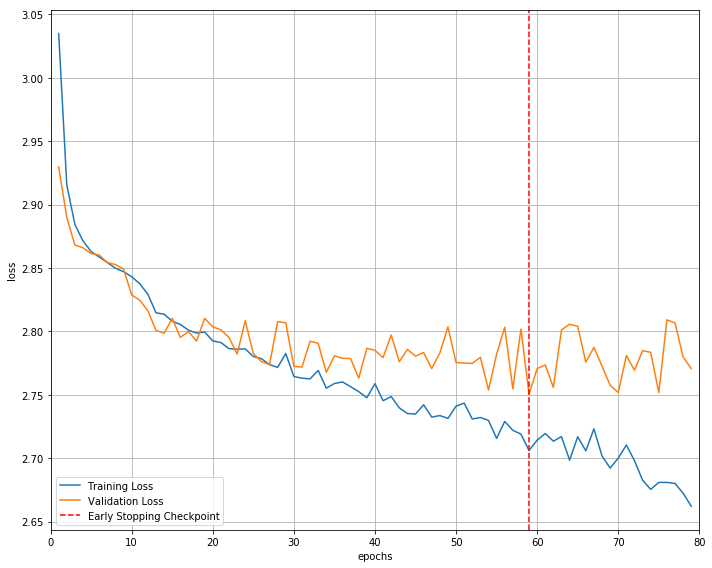

In [25]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = val_loss.index(min(val_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')